In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import matplotlib.style as style
style.use('seaborn-whitegrid')

import os
import pprint
# import googlemaps
# import time
import pickle
from random import randint
from collections import defaultdict

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, TreebankWordTokenizer, wordpunct_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.util import ngrams
from nltk.corpus import stopwords

from textblob import TextBlob

import string



In [4]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [117]:
# Set pandas options
pd.set_option('max_rows', 10)
# pd.set_option('max_colwidth', -1)
# pd.set_option('display.width', 150)
pd.set_option('display.max_rows', 30)
# pd.set_option('display.max_columns', None)

*Load the relevant data file*

In [10]:
# df = pd.read_csv('data/cleaned_reviews.csv')

# df = pd.read_csv('data/listing_descriptions.csv', index_col=0)
df = pd.read_csv('data/cleaned_df.csv', index_col='Unnamed: 0')

In [11]:
df.head(2)

,id,host_id,host_listings_count,host_total_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,room_type,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,7893,21489,1,1,Piedmont,97217,45.575479,-122.666777,House,Entire home/apt,...,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.02
1,12899,49682,1,1,Concordia,97211,45.564010,-122.634717,Guest suite,Private room,...,497,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,4.69


In [12]:
df.shape

(5405, 28)

In [13]:
df.columns

Index(['id', 'host_id', 'host_listings_count', 'host_total_listings_count',
       'neighbourhood', 'zipcode', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'guests_included',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month'],
      dtype='object')

In [48]:
df['amenities'] = df['amenities'].apply(lambda z: [x for x in re.findall('[^{},"]*', z) if x !=''])

In [76]:
counts = defaultdict(int)

for i in range(5044):
    for amenity in df['amenities'][i]:
        counts[amenity] += 1

sorted(counts.items(), reverse=True, key=lambda tup: tup[1])[:70]

[('Wifi', 4971),
 ('Essentials', 4924),
 ('Heating', 4906),
 ('Smoke detector', 4848),
 ('Shampoo', 4395),
 ('Kitchen', 4368),
 ('Hangers', 4361),
 ('Carbon monoxide detector', 4350),
 ('Hair dryer', 4120),
 ('Laptop friendly workspace', 3961),
 ('Iron', 3885),
 ('Fire extinguisher', 3730),
 ('TV', 3615),
 ('Washer', 3518),
 ('Dryer', 3515),
 ('Hot water', 3434),
 ('First aid kit', 2948),
 ('Self check-in', 2909),
 ('Air conditioning', 2839),
 ('Free street parking', 2797),
 ('Family/kid friendly', 2645),
 ('Free parking on premises', 2556),
 ('Refrigerator', 2296),
 ('Dishes and silverware', 2213),
 ('Private entrance', 2103),
 ('Bed linens', 2082),
 ('Coffee maker', 2059),
 ('Microwave', 1956),
 ('Internet', 1906),
 ('Cooking basics', 1842),
 ('Stove', 1781),
 ('Extra pillows and blankets', 1770),
 ('Oven', 1706),
 ('Luggage dropoff allowed', 1596),
 ('Lock on bedroom door', 1490),
 ('Long term stays allowed', 1422),
 ('Dishwasher', 1364),
 ('Garden or backyard', 1342),
 ('Indoor fir

In [101]:
# Use regex and for loop to make syntax of one-hot encoding easier :)
for x in ['Gym', 'Kitchen', 'Pets allowed', 'Hot tub', 'Washer', 'Refrigerator', 'Air conditioning', 'Family/kid friendly', 'Private entrance', 'Indoor fireplace', 'Patio or balcony', 'Cable TV', '24-hour check-in', 'Bathtub']:
    print(f"df['amenities_{x.lower().replace(' ', '_').replace('/', '_').replace('-', '_')}'] = df['amenities'].apply(lambda x: 1 if '{x}' in set(x) else 0)")

df['amenities_gym'] = df['amenities'].apply(lambda x: 1 if 'Gym' in set(x) else 0)
df['amenities_kitchen'] = df['amenities'].apply(lambda x: 1 if 'Kitchen' in set(x) else 0)
df['amenities_pets_allowed'] = df['amenities'].apply(lambda x: 1 if 'Pets allowed' in set(x) else 0)
df['amenities_hot_tub'] = df['amenities'].apply(lambda x: 1 if 'Hot tub' in set(x) else 0)
df['amenities_washer'] = df['amenities'].apply(lambda x: 1 if 'Washer' in set(x) else 0)
df['amenities_refrigerator'] = df['amenities'].apply(lambda x: 1 if 'Refrigerator' in set(x) else 0)
df['amenities_air_conditioning'] = df['amenities'].apply(lambda x: 1 if 'Air conditioning' in set(x) else 0)
df['amenities_family_kid_friendly'] = df['amenities'].apply(lambda x: 1 if 'Family/kid friendly' in set(x) else 0)
df['amenities_private_entrance'] = df['amenities'].apply(lambda x: 1 if 'Private entrance' in set(x) else 0)
df['amenities_indoor_fireplace'] = df['amenities'].apply(lambda x: 1 if 'Indoor fireplace' in set(x) else 0)
df

In [99]:
# One hot encode all of the relevant amenities
df['amenities_gym'] = df['amenities'].apply(lambda x: 1 if 'Gym' in set(x) else 0)
df['amenities_kitchen'] = df['amenities'].apply(lambda x: 1 if 'Kitchen' in set(x) else 0)
df['amenities_pets_allowed'] = df['amenities'].apply(lambda x: 1 if 'Pets allowed' in set(x) else 0)
df['amenities_hot_tub'] = df['amenities'].apply(lambda x: 1 if 'Hot tub' in set(x) else 0)
df['amenities_washer'] = df['amenities'].apply(lambda x: 1 if 'Washer' in set(x) else 0)
df['amenities_refrigerator'] = df['amenities'].apply(lambda x: 1 if 'Refrigerator' in set(x) else 0)
df['amenities_air_conditioning'] = df['amenities'].apply(lambda x: 1 if 'Air conditioning' in set(x) else 0)
df['amenities_family_kid_friendly'] = df['amenities'].apply(lambda x: 1 if 'Family/kid friendly' in set(x) else 0)
df['amenities_private_entrance'] = df['amenities'].apply(lambda x: 1 if 'Private entrance' in set(x) else 0)
df['amenities_indoor_fireplace'] = df['amenities'].apply(lambda x: 1 if 'Indoor fireplace' in set(x) else 0)
df['amenities_patio_or_balcony'] = df['amenities'].apply(lambda x: 1 if 'Patio or balcony' in set(x) else 0)
df['amenities_cable_tv'] = df['amenities'].apply(lambda x: 1 if 'Cable TV' in set(x) else 0)
df['amenities_24_hour_check_in'] = df['amenities'].apply(lambda x: 1 if '24-hour check-in' in set(x) else 0)
df['amenities_bathtub'] = df['amenities'].apply(lambda x: 1 if 'Bathtub' in set(x) else 0)

In [119]:
df.head(2)

,id,host_id,host_listings_count,host_total_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,room_type,...,amenities_washer,amenities_refrigerator,amenities_air_conditioning,amenities_family_kid_friendly,amenities_private_entrance,amenities_indoor_fireplace,amenities_patio_or_balcony,amenities_cable_tv,amenities_24_hour_check_in,amenities_bathtub
0,7893,21489,1,1,Piedmont,97217,45.575479,-122.666777,House,Entire home/apt,...,1,0,0,0,0,1,0,0,0,0
1,12899,49682,1,1,Concordia,97211,45.564010,-122.634717,Guest suite,Private room,...,0,0,1,0,0,0,0,0,1,0


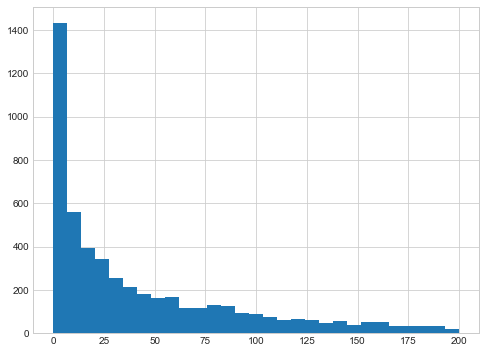

In [127]:
plt.figure(figsize=(8,6))
plt.hist(df['number_of_reviews'], bins='auto', range=(0,200), align=');

In [118]:
df['review_scores_rating'].value_counts()

100.0    1258
99.0      857
98.0      773
97.0      530
96.0      399
95.0      260
94.0      175
93.0      163
90.0      105
92.0       89
91.0       61
80.0       41
89.0       35
88.0       32
87.0       24
         ... 
83.0        8
84.0        7
81.0        6
82.0        6
73.0        5
77.0        3
70.0        3
67.0        1
40.0        1
20.0        1
78.0        1
76.0        1
68.0        1
55.0        1
79.0        1
Name: review_scores_rating, Length: 33, dtype: int64

In [19]:
import re

In [40]:
r = re.findall('[^{},"]*', df['amenities'][0])

In [41]:
df['amenities'][0]

'{TV,Wifi,Kitchen,"Free parking on premises","Indoor fireplace",Washer,Dryer,"Smoke detector","Fire extinguisher"}'

In [43]:
[x for x in re.findall('[^{},"]*', z) if x !='']

['TV',
 'Wifi',
 'Kitchen',
 'Free parking on premises',
 'Indoor fireplace',
 'Washer',
 'Dryer',
 'Smoke detector',
 'Fire extinguisher']

In [38]:
r

['TV',
 'Wifi',
 '',
 'Kitchen',
 '',
 '',
 'Free parking on premises',
 '',
 '',
 '',
 'Indoor fireplace',
 '',
 '',
 'Washer',
 '',
 'Dryer',
 '',
 '',
 'Smoke detector',
 '',
 '',
 '',
 'Fire extinguisher',
 '',
 '}',
 '']